# Predicting Sentiment in Tweets Involving the Dallas Mavericks

#### Brian Johns, May 2023

## Notebook #3: Predicting Sentiment Using Classification Models

In notebooks #1 and #2, I gathered the data, cleaned it, conducted NLP and did some initial exploratory data analysis.  Now, with the data ready for modeling, I will analyze the data further to get a sense of the relationships between the features and `Sentiment` and then use classification models in order to predict `Sentiment`.

In this notebook, I will do the following:

1. [Load Data](#loading)
2. [EDA on Relationships with Sentiment](#eda)
3. [Classification Modelling using Logistic Regression](#logreg)
4. [Classification Modelling using Naive Bayes](#bayes)
5. [Model Evaluation](#evaluation)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geonamescache

import unidecode

import regex as re

import pickle

import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE

<a id = 'loading'></a>

## 1. Load Data

In [2]:
X_train_full = pd.read_pickle('mavs_X_train.pickle')
y_train_full = pd.read_pickle('mavs_y_train.pickle')
X_test = pd.read_pickle('mavs_X_test.pickle')
y_test = pd.read_pickle('mavs_y_test.pickle')

In [3]:
X_train_full.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,yes yes yes,yessir,yesterday,yo,york,york knicks,young,yr,zero,zone
0,0,0,0,30,505,0,0,1,0,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,642,4980,0,0,0,0,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,36,337,0,0,0,1,9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,1,15251,5661,1,0,1,0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,2,54,375,0,1,0,0,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
y_train_full

0         Positive
1         Positive
2          Neutral
3         Positive
4         Positive
            ...   
210327     Neutral
210328    Positive
210329     Neutral
210330    Positive
210331    Negative
Name: Sentiment, Length: 210332, dtype: object

In [5]:
X_test.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,yes yes yes,yessir,yesterday,yo,york,york knicks,young,yr,zero,zone
0,1,0,0,716,789,0,0,0,1,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0,0,0,167,849,0,0,1,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0,0,0,943,3133,0,1,0,0,22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594783,0.0,0.0
3,0,0,0,5584,2222,1,0,0,0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0,0,0,9,53,0,0,0,0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [6]:
y_test

0        Positive
1         Neutral
2         Neutral
3         Neutral
4         Neutral
           ...   
52579    Positive
52580     Neutral
52581     Neutral
52582    Negative
52583    Negative
Name: Sentiment, Length: 52584, dtype: object

Here I will also set up a couple of helper functions.

The first will be to visualize the top coefficients of my models.  Given that there will be over 2000+ features with each token, this will be a good way to see which features are having the greatest effect on each model.

The second function will be used to streamline the model evaluation process.  Once a model has been fitted, I can use this model to give me the most important things for evaluating the model, namely an Accuracy score, Classification Report for precision and recall and a Confusion Matrix for the predictions.

In [7]:
# Helper Function that will plot out the Top 20 features, likely to be tokens
def plot_coefs(model, X):
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "feature": X.columns})
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # largest negative coefficients - May not align with Positive/Negative Sentiment based on Model
    coef_df.tail(20).set_index("feature").plot(kind="bar", rot=45, ax=axs[0], color="red")
    axs[0].set_title("Negative indicators")
 
    
    # largest positive coefficients - May not align with Positive/Negative Sentiment based on Model
    coef_df.head(20).set_index("feature").plot(kind="bar", rot=45, ax=axs[1], color="blue")
    axs[1].set_title("Positive indicators")
    
    sns.despine()
    plt.tight_layout()
    plt.show()

In [8]:
def model_eval(model, X_train, X_test, y_train, y_test):    
    # Evaluate the Model
    predictions = model.predict(X_test)
    print(f'Training Score: {round(model.score(X_train, y_train)*100, 4)}%')
    print(f'Testing Score: {round(model.score(X_test, y_test)*100, 4)}%')
    print(classification_report(y_test, predictions))
    ConfusionMatrixDisplay.from_predictions(y_test, predictions)
    plt.xticks(rotation = 30)

<a id = 'loading'></a>

## 2. EDA on Relationships between Features and `Sentiment`
### `Sentiment`

First, I want to see the basic distribution of our target variable: `Sentiment`.

In [9]:
y_train_full.value_counts(normalize = True)*100

Positive    41.523877
Neutral     39.433372
Negative    19.042751
Name: Sentiment, dtype: float64

In [10]:
sentiment_values = y_train_full.value_counts(normalize = True)

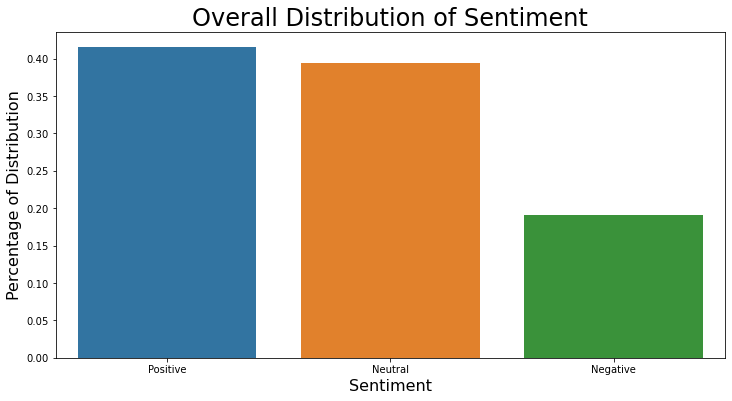

In [102]:
plt.figure(figsize = (12,6))
sns.barplot(x = sentiment_values.index, y = sentiment_values.values)
plt.title('Overall Distribution of Sentiment', fontsize = 24)
plt.ylabel('Percentage of Distribution', fontsize = 16)
plt.xlabel('Sentiment', fontsize = 16)
plt.show()

There is a bit of an imbalance in the dataset.  **Positive** and **Neutral** sentiments have about 40% of the share, whereas **Negative** Sentiments have a little less than 20%.

This imbalance could be an issue when developing a model to accurately classify the `Sentiment` and will likely require SMOTE to balance the dataset for better predictions.

### `Location`

In order to do a more thorough data analysis on the dataset and the relationships between the features and the `Sentiment` target variable, I will recombine the target data for the training set with the features.

In [12]:
mavs_df = pd.concat([X_train_full, y_train_full], axis = 1)

In [13]:
mavs_df2 = mavs_df.iloc[:, :22]
mavs_df2['Sentiment'] = mavs_df['Sentiment']
mavs_df2.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent,Sentiment
0,0,0,0,30,505,0,0,1,0,12,...,0,0.617647,0,0,0,0,0,0,0,Positive
1,0,0,1,642,4980,0,0,0,0,14,...,0,0.583333,0,0,0,1,0,1,0,Positive
2,0,0,0,36,337,0,0,0,1,9,...,1,0.468750,0,0,0,0,0,0,0,Neutral
3,0,1,1,15251,5661,1,0,1,0,11,...,0,0.622222,0,0,0,1,1,0,0,Positive
4,1,0,2,54,375,0,1,0,0,23,...,1,0.627660,0,0,0,1,1,0,0,Positive


In [14]:
sentiment_df = mavs_df2.groupby('Sentiment').mean().reset_index()

In [15]:
sentiment_df.head()

,Sentiment,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,...,Win,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent
0,Negative,0.655556,1.329813,12.001198,53843.425711,845.453724,0.048960,0.213517,0.146606,0.529648,...,0.363543,0.683694,0.583753,0.087284,0.111802,0.099019,0.234639,0.216613,0.237011,0.294060
1,Neutral,0.926960,4.679266,34.696326,157637.313886,967.439059,0.072883,0.187603,0.162272,0.473626,...,0.432524,0.705586,0.577842,0.112839,0.130430,0.091812,0.226161,0.282791,0.217371,0.267371
2,Positive,0.812144,2.910142,25.153564,96679.661075,1042.648320,0.061588,0.204836,0.156690,0.524148,...,0.391365,0.649442,0.579798,0.112540,0.112929,0.113124,0.221003,0.224473,0.239964,0.295461


In [16]:
location_list = [col for col in sentiment_df.columns if 'Location_' in col]

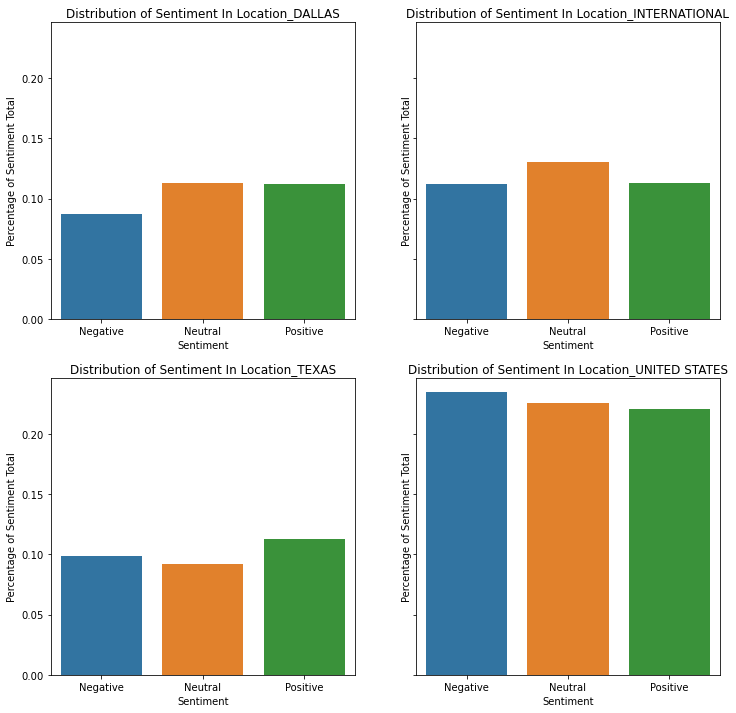

In [100]:
plt.subplots(2, 2, figsize = (12, 12), sharey = True)

for n, location in enumerate(location_list):
    plt.subplot(2, 2, n+1)
    sns.barplot(x = sentiment_df['Sentiment'], y = sentiment_df[location])
    plt.title(f'Distribution of Sentiment In {location}')
    plt.ylabel('Percentage of Sentiment Total')

plt.show()

There seems to be a relative balance between the locations and `Sentiment`.  Dallas, Texas and International locations have a relatively equal distribution of around 10% of each Sentiment.  The United States has a 20% of each Sentiment, but still relatively equal.  That means that about 50% of all tweets would be classified as 'Unknown' location, but also relatively equally distributed.  It would not seem that location is much of a predictor for `Sentiment`

### `Verified`

In [18]:
verified_df = pd.crosstab(mavs_df2['Sentiment'], mavs_df2['Verified'])

In [19]:
counts_df = mavs_df2.groupby('Sentiment').count().reset_index()

In [20]:
verified_df['Percentage'] = verified_df[1] / (verified_df[0] + verified_df[1])*100

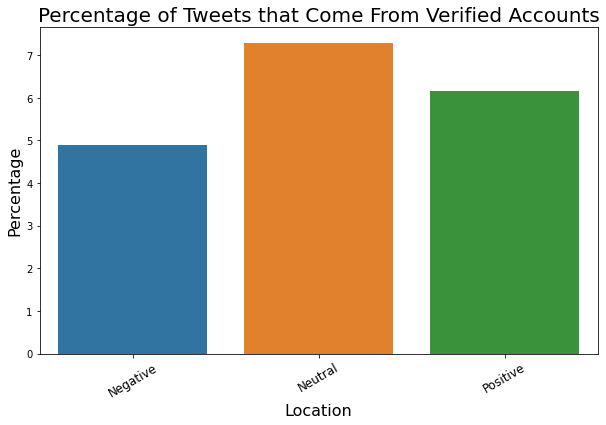

In [21]:
plt.figure(figsize = (10, 6))
sns.barplot(x = verified_df.index, y = verified_df['Percentage'])
plt.title('Percentage of Tweets that Come From Verified Accounts', fontsize = 20)
plt.xlabel('Location', fontsize = 16)
plt.ylabel('Percentage', fontsize = 16)
plt.xticks(rotation = 30, fontsize = 12)
plt.show()

It seems that tweets that are Neutral have a higher percentage of tweets that come from verified accounts.  Perhaps there are accounts that are more news based and would be verified but also more likely to just distribute straight forward information, making it more likely that their tweets have a Neutral `Sentiment`.

That being said, these percentages are still pretty close together, ranging from around 5-7% of tweets coming from verified accounts for each Sentiment.  Hard to say if there will be any predictive value from Verified Accounts in predicting `Sentiment`.

### Numeric Columns: Counts

Replies, Retweets, Likes, Followers and Friends are *counted* for each tweet.  We will look at their relationship with `Sentiment` together here.

In [22]:
sum_df = mavs_df2.groupby('Sentiment').sum()

In [23]:
sum_df['Total_Tweets'] = mavs_df2.value_counts('Sentiment')

In [24]:
sum_df.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent,Total_Tweets
Sentiment,,,,,,,,,,,,,,,,,,,,,
Negative,26257,53263,480684,2156590730,33862958,1961,8552.0,5872.0,21214.0,646808,...,27384,23381.074718,3496.0,4478.0,3966.0,9398.0,8676,9493,11778,40053
Neutral,76883,388103,2877748,13074596451,80240363,6045,15560.0,13459.0,39283.0,1310860,...,58522,47926.809601,9359.0,10818.0,7615.0,18758.0,23455,18029,22176,82941
Positive,70931,254166,2196862,8443808239,91062819,5379,17890.0,13685.0,45778.0,1359797,...,56721,50638.367798,9829.0,9863.0,9880.0,19302.0,19605,20958,25805,87338


In [25]:
category_list = ['reply count', 'retweet count', 'like count', 'Follower Count', ' Friends Count']

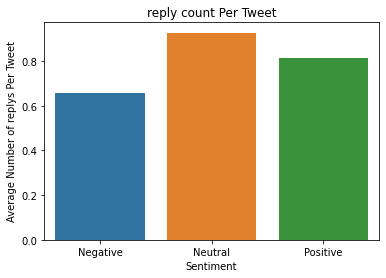

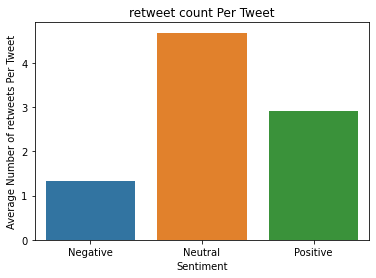

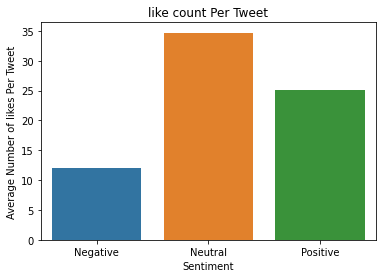

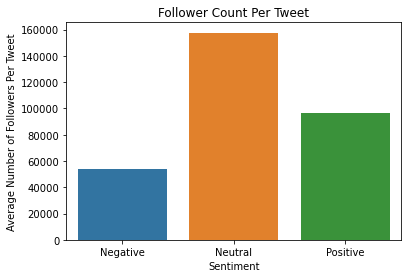

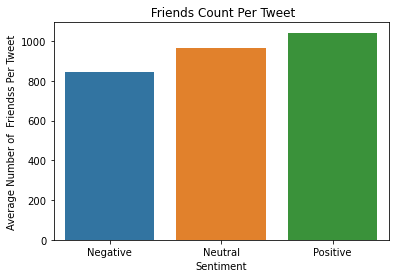

In [26]:
for category in category_list:
    plt.figure()
    sns.barplot(x = sum_df.index,
               y = sum_df[category]/sum_df['Total_Tweets'])
    plt.title(f'{category} Per Tweet')
    plt.ylabel(f'Average Number of {category[:-6]}s Per Tweet')
    plt.xlabel('Sentiment')
    plt.show()

It seems in each of these categories, Neutral has the highest amount, followed by Positive with Negative having the fewest for the average number for each tweet.  This could be similar to verified accounts, where there would be a greater number of followers, therefore a greater number of interactions, but have a higher proportion of straight forward information.

There does seem to be some differentiation here, but I would like to see if there's a difference between those with any interaction, versus tweets with no interaction at all.

In [27]:
engaged_df = mavs_df2[(mavs_df2['reply count'] > 0) &
       (mavs_df2['retweet count'] > 0) &
       (mavs_df2['like count'] > 0) &
       (mavs_df2['Follower Count'] > 0) &
       (mavs_df2[' Friends Count'] > 0)]

In [28]:
engaged_sum_df = engaged_df.groupby('Sentiment').sum()

In [29]:
engaged_sum_df['Total_Tweets'] = engaged_df.value_counts('Sentiment')

In [30]:
engaged_sum_df.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent,Total_Tweets
Sentiment,,,,,,,,,,,,,,,,,,,,,
Negative,15752,49970,416511,1899383825,3265740,726,147.0,416.0,715.0,25223,...,1048,920.728921,433.0,134.0,116.0,402.0,582,347,384,1597
Neutral,62346,375704,2725961,12484505963,7623033,2976,355.0,1449.0,1957.0,81378,...,3623,2766.466050,2332.0,328.0,229.0,794.0,2793,824,786,4859
Positive,49908,241942,2016605,7809803875,10741747,2153,435.0,1034.0,2352.0,72769,...,3037,2688.656207,1644.0,340.0,334.0,995.0,1895,1101,1096,4721


In [31]:
category_list = ['reply count', 'retweet count', 'like count', 'Follower Count', ' Friends Count']

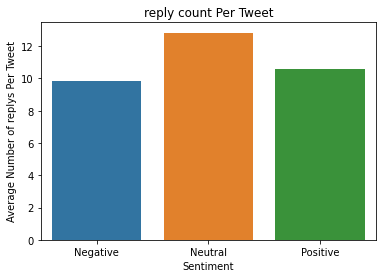

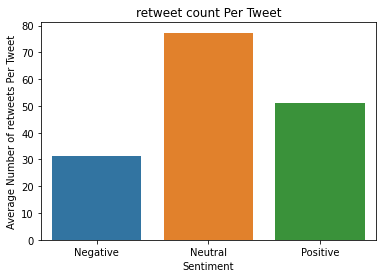

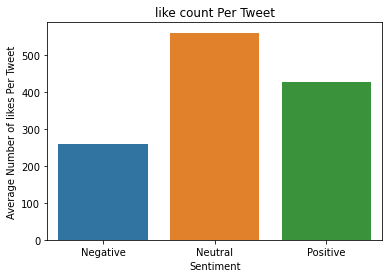

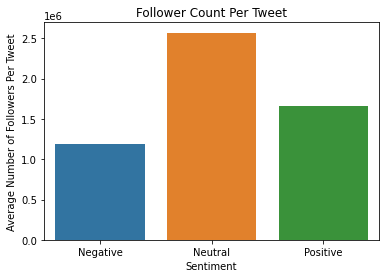

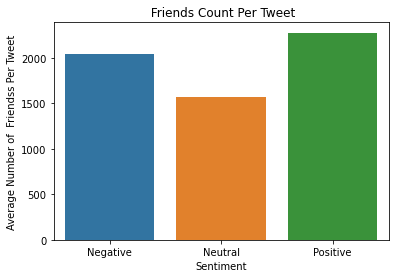

In [32]:
for category in category_list:
    plt.figure()
    sns.barplot(x = engaged_sum_df.index,
               y = engaged_sum_df[category]/engaged_sum_df['Total_Tweets'])
    plt.title(f'{category} Per Tweet')
    plt.ylabel(f'Average Number of {category[:-6]}s Per Tweet')
    plt.xlabel('Sentiment')
    plt.show()

These distributions are about the same, with the exception of the average number of Friends for each tweet.  The average number of friends rises significantly for tweets with a negative `Sentiment` when looking at tweets that have some engagement.  Perhaps there are more tweets with a `Negative` Sentiment that do not gain any traction compared to Neutral and Positive tweets.

### `Access_`

Here I will see if there is any difference between how a user tweets compared to the `Sentiment`

In [33]:
mean_df = mavs_df2.groupby('Sentiment').mean()

In [34]:
mean_df.head()

,reply count,retweet count,like count,Follower Count,Friends Count,Verified,Access_Android,Access_Web_App,Access_iPhone,Hour,...,Win,Gameday,Winning_Pct,Location_DALLAS,Location_INTERNATIONAL,Location_TEXAS,Location_UNITED STATES,Tweets_Weekly,Tweets_Monthly,Tweets_Infrequent
Sentiment,,,,,,,,,,,,,,,,,,,,,
Negative,0.655556,1.329813,12.001198,53843.425711,845.453724,0.048960,0.213517,0.146606,0.529648,16.148803,...,0.363543,0.683694,0.583753,0.087284,0.111802,0.099019,0.234639,0.216613,0.237011,0.294060
Neutral,0.926960,4.679266,34.696326,157637.313886,967.439059,0.072883,0.187603,0.162272,0.473626,15.804729,...,0.432524,0.705586,0.577842,0.112839,0.130430,0.091812,0.226161,0.282791,0.217371,0.267371
Positive,0.812144,2.910142,25.153564,96679.661075,1042.648320,0.061588,0.204836,0.156690,0.524148,15.569363,...,0.391365,0.649442,0.579798,0.112540,0.112929,0.113124,0.221003,0.224473,0.239964,0.295461


In [35]:
access_cols = [col for col in mean_df.columns if 'Access_' in col]

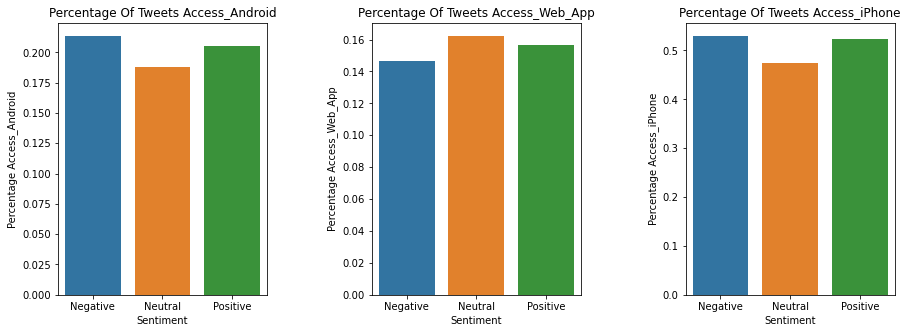

In [36]:
plt.figure(figsize = (15, 5))
plt.subplots_adjust(wspace=0.5)

for n, col in enumerate(access_cols):
    ax = plt.subplot(1, 3, n + 1)
    
    sns.barplot(x = mean_df.index,
                y = mean_df[col],
                ax = ax)
    plt.title(f'Percentage Of Tweets {col}')
    plt.ylabel(f'Percentage {col}')
    plt.xlabel('Sentiment')

plt.show()

Not a lot of differentiation here, though there seems to be a higher proportion of Neutral Sentiment when using twitter from the web_app.  Maybe that's how a lot of the verified accounts distribute their information.

### Time including `Hour`, `Day`, `Day_Of_Season`

In [37]:
sentiment_list = list(mavs_df2['Sentiment'].value_counts().index)

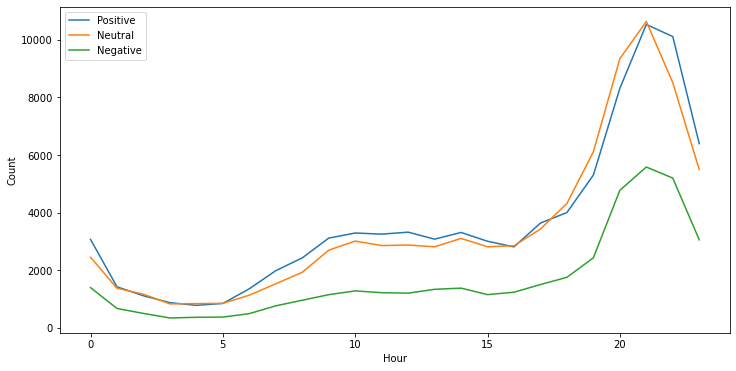

In [38]:
hour_ct = pd.crosstab(mavs_df2['Hour'], mavs_df2['Sentiment'])

plt.figure(figsize = (12,6))
for sentiment in sentiment_list:
    sns.lineplot(x = hour_ct.index, y = hour_ct[sentiment])
plt.ylabel('Count')
plt.legend(sentiment_list)
plt.show()

It's clear that more tweets are sent during game time (19th hour and later) so I'm curious as to how the result of the game impacts the `Sentiment` of the tweets, and see if there are any differences between the `Sentiment` of tweets from people from Dallas and outside of it.

In [39]:
games_df = mavs_df2[(mavs_df2['Gameday'] == 1) & (mavs_df2['Hour'] >= 19)]
dallas_games_df = mavs_df2[(mavs_df2['Gameday'] == 1) & (mavs_df2['Hour'] >= 19) & (mavs_df2['Location_DALLAS'] == 1)]
notdallas_games_df = mavs_df2[(mavs_df2['Gameday'] == 1) & (mavs_df2['Hour'] >= 19) & (mavs_df2['Location_DALLAS'] == 0)]

In [40]:
winning_ct = pd.crosstab(games_df['Win'], games_df['Sentiment'], normalize = 'index')
dallas_ct = pd.crosstab(dallas_games_df['Win'], dallas_games_df['Sentiment'], normalize = 'index')
notdallas_ct = pd.crosstab(notdallas_games_df['Win'], notdallas_games_df['Sentiment'], normalize = 'index')

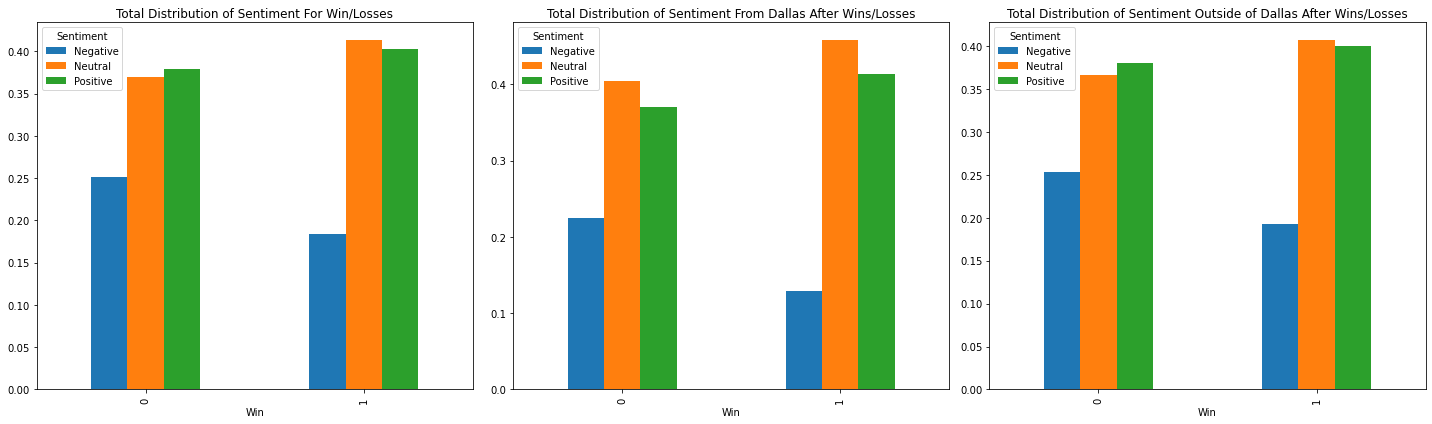

In [41]:
fig, axs = plt.subplots(1, 3, figsize = (20,6))

winning_ct.plot.bar(ax = axs[0])
axs[0].set_title('Total Distribution of Sentiment For Win/Losses')

dallas_ct.plot.bar(ax = axs[1])
axs[1].set_title('Total Distribution of Sentiment From Dallas After Wins/Losses')

notdallas_ct.plot.bar(ax = axs[2])
axs[2].set_title('Total Distribution of Sentiment Outside of Dallas After Wins/Losses')

plt.tight_layout()

plt.show()

Unsurprisingly, the distribution of positive tweets increased after a win, but so too did Neutral tweets.  Perhaps game score updates (ie. 'Final Score: Dallas 98, San Antonio 97') would be considered purely neutral even though it shows a positive result for Dallas.

Interestingly, it looks as though the overall distribution was driven by changes ONLY from the tweets that originated from Dallas.  Dallas tweets were less negative overall between wins and losses, but the negative `Sentiment` tweets dropped significantly more leading to the overall increase in neutral and positive tweets.

While the `Sentiment` of tweets from outside of Dallas reflected the Total distribution, that is interesting within itself.  Despite coming from outside of Dallas, tweets with positive and neutral `Sentiment` still increased after a win even though, presumably, the tweets did not come from hometown fans.

Next I'll look at tweets through the days of the week.

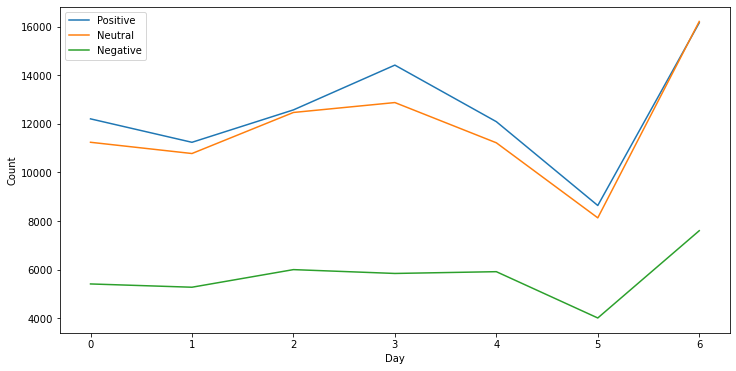

In [42]:
day_ct = pd.crosstab(mavs_df2['Day'], mavs_df2['Sentiment'])

plt.figure(figsize = (12,6))
for sentiment in sentiment_list:
    sns.lineplot(x = day_ct.index, y = day_ct[sentiment])
plt.ylabel('Count')
plt.legend(sentiment_list)
plt.show()

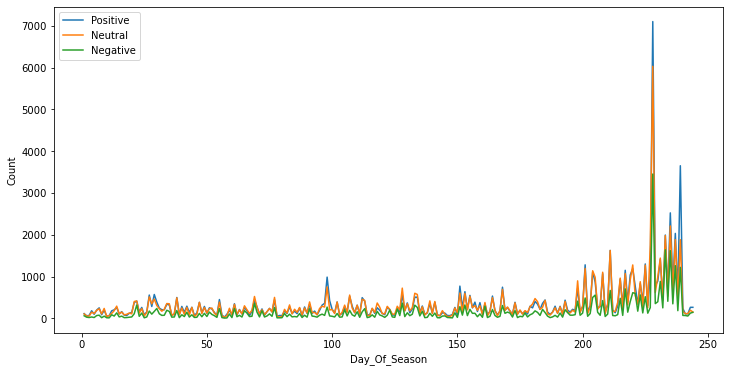

In [43]:
dos_ct = pd.crosstab(mavs_df2['Day_Of_Season'], mavs_df2['Sentiment'])

plt.figure(figsize = (12,6))
for sentiment in sentiment_list:
    sns.lineplot(x = dos_ct.index, y = dos_ct[sentiment])
plt.ylabel('Count')
plt.legend(sentiment_list)
plt.show()

Looking at each of these trends over time, it appears that while the overall volume of tweets varies over time, the relationship between the `Sentiment` of each tweet is mirrored for all three sentiments.  However, it does seem that the variation of Negative tweets over time is dampened compared to Negative and Positive tweets, but it's hard to say if that's a result of there being fewer Negative tweets overall, or if it's a trend that could be used to predict the `Sentiment` of the tweet.

### Performance, including `Win` and `Winning_Pct`

In [44]:
win_ct = pd.crosstab(mavs_df2['Win'], mavs_df2['Sentiment'], normalize = 'index')
win_ct

Sentiment,Negative,Neutral,Positive
Win,,,
0,0.202775,0.374391,0.422834
1,0.172083,0.423962,0.403954


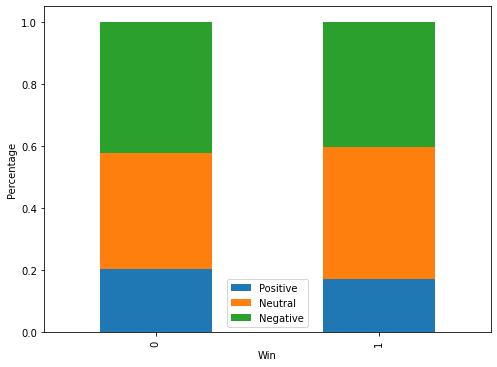

In [45]:
win_ct.plot(kind = 'bar', stacked = True, figsize = (8, 6))
plt.ylabel('Percentage')
plt.legend(sentiment_list)
plt.show()

Interestingly, it seems that after a loss, there is less Neutral `Sentiment` but a higher proportion of Positive AND Negative `Sentiment`.  Therefore the `Sentiment` seems to get more polarized after a loss.

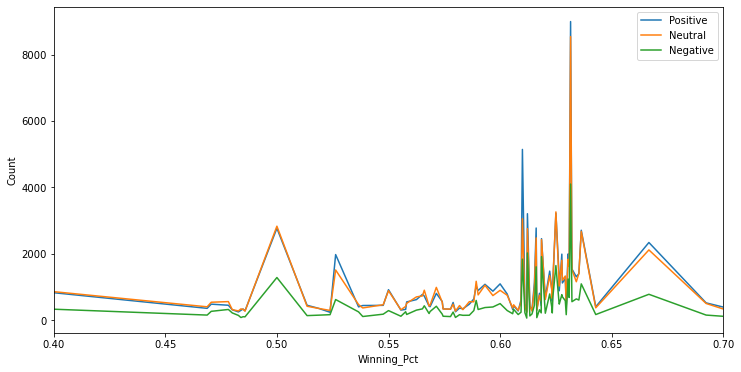

In [46]:
dos_ct = pd.crosstab(mavs_df2['Winning_Pct'], mavs_df2['Sentiment'])

plt.figure(figsize = (12,6))
for sentiment in sentiment_list:
    sns.lineplot(x = dos_ct.index, y = dos_ct[sentiment])
plt.ylabel('Count')
plt.legend(sentiment_list)
plt.xlim(0.4, 0.7)
plt.show()

In [47]:
new_dos_df = pd.DataFrame()

In [48]:
new_dos_df['<50%'] = dos_ct.loc[dos_ct.index < 0.5].sum()
new_dos_df['50-55%'] = dos_ct.loc[(dos_ct.index >= 0.5) & (dos_ct.index < 0.55)].sum()
new_dos_df['55-60%'] = dos_ct.loc[(dos_ct.index >= 0.55) & (dos_ct.index < 0.6)].sum()
new_dos_df['60-65%'] = dos_ct.loc[(dos_ct.index >= 0.6) & (dos_ct.index < 0.65)].sum()
new_dos_df['>65%'] = dos_ct.loc[dos_ct.index >= 0.65].sum()

In [49]:
new_dos_df = new_dos_df.T

In [50]:
pct_list = list(new_dos_df.index)

In [51]:
sentiment_list

['Positive', 'Neutral', 'Negative']

In [52]:
new_dos_df['Sum'] = 0

for pct in pct_list:
    new_dos_df['Sum'][pct] = new_dos_df['Positive'][pct] + new_dos_df['Negative'][pct] + new_dos_df['Neutral'][pct]
    for sentiment in sentiment_list:
        new_dos_df[sentiment][pct] = new_dos_df[sentiment][pct]/new_dos_df['Sum'][pct]

new_dos_df.drop(columns = 'Sum', inplace = True)

new_dos_df

/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_66422/2174213284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dos_df[sentiment][pct] = new_dos_df[sentiment][pct]/new_dos_df['Sum'][pct]
/var/folders/dm/5cg2631s7057bxm5mx52z5fr0000gn/T/ipykernel_66422/2174213284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dos_df['Sum'][pct] = new_dos_df['Positive'][pct] + new_dos_df['Negative'][pct] + new_dos_df['Neutral'][pct]


Sentiment,Negative,Neutral,Positive
<50%,0.176320,0.418921,0.404759
50-55%,0.174069,0.402056,0.423875
55-60%,0.179031,0.415063,0.405906
60-65%,0.199669,0.384264,0.416067
>65%,0.146038,0.412916,0.441045


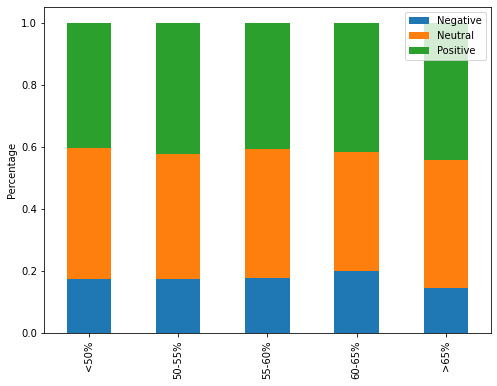

In [53]:
new_dos_df.plot(kind = 'bar', stacked = True, figsize = (8, 6))
plt.ylabel('Percentage')
plt.legend()
plt.show()

There does not seem to be much of a correlation between `Winning_Pct` and `Sentiment`.  If anything, there does seem to be a higher percentage of Positive tweets when the Mavs record was over 65%, but it is not very distinctive compared to the rest of the data.

### Frequency of Tweets, including `Tweets_Weekly`, `Tweets_Monthly`, `Tweets_Infrequent`

In [54]:
freq_cols = [col for col in mean_df.columns if 'Tweets_' in col]

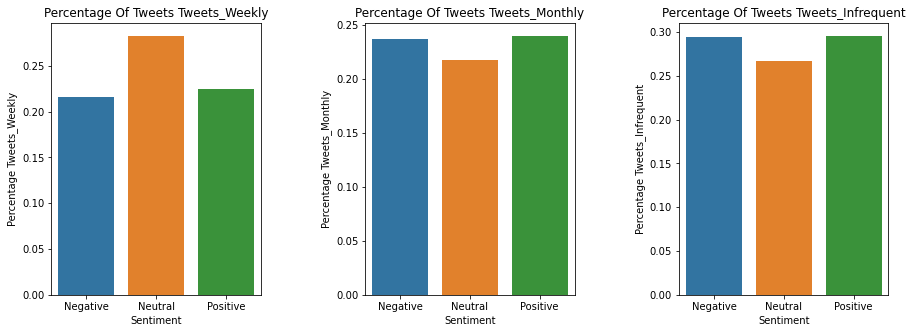

In [55]:
plt.figure(figsize = (15, 5))
plt.subplots_adjust(wspace=0.5)

for n, col in enumerate(freq_cols):
    ax = plt.subplot(1, 3, n + 1)
    
    sns.barplot(x = mean_df.index,
                y = mean_df[col],
                ax = ax)
    plt.title(f'Percentage Of Tweets {col}')
    plt.ylabel(f'Percentage {col}')
    plt.xlabel('Sentiment')

plt.show()

As identified in the previous notebook, it looks as though that `Tweets_Weekly` could help predict Neutral `Sentiment`, but there isn't much that differentiates Positive and Negative `Sentiment` using the frequency of tweets.

Looking through, of the non-NLP features, the areas that seem most promising to help predict `Sentiment` look to be:

- `Tweets_Weekly`
- `Retweet Count`
- `Like Count`
- `Follower Count`
- `Win`

However, there are not a lot of features so far that look to be highly predictive of `Sentiment`.  As I try to establish models that will help to predict `Sentiment`, the combination of these factors with the vectorized tokens will help shape a model that is more predictive.

<a id = 'logreg'></a>

## 3. Classification Modeling Using Logistic Regression

To start, I will split the data into training and validation sets.  The previous train/test split has established our final testing data and has continued to be unused in this analysis/modeling to prevent data leakage.

After that I will do a basic logistic regression model.  Considering that the classifications for this data is unbalanced (40% Positive, 40% Neutral, 20% Negative) I will apply SMOTE to the full training data set, which will allow me to start modeling using both imbalanced and balanced data in order to evaluate the most appropriate model to use here.

In [56]:
# Split the data.  25% split here makes it 60% Training, 20% Validation, 20% Testing
# First with the unbalanced dataset
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_full,
                                                  y_train_full,
                                                  stratify = y_train_full,
                                                  test_size = .25,
                                                  random_state = 77)

In [57]:
# Applying SMOTE
X_train, y_train = SMOTE(random_state = 77).fit_resample(X_train_split, y_train_split)

In [58]:
logreg = LogisticRegression(multi_class = 'multinomial',
                            max_iter = 1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

Training Score: 33.9705%
Testing Score: 41.7264%
              precision    recall  f1-score   support

    Negative       0.19      0.03      0.05     10013
     Neutral       0.58      0.03      0.06     20735
    Positive       0.42      0.96      0.59     21835

    accuracy                           0.42     52583
   macro avg       0.40      0.34      0.23     52583
weighted avg       0.44      0.42      0.27     52583



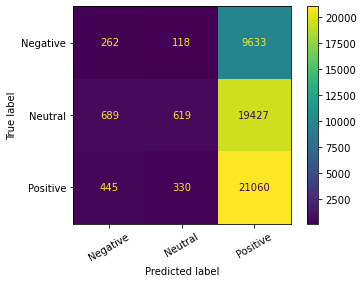

In [59]:
model_eval(logreg, X_train, X_val, y_train, y_val)

Unfortunately, the clean data set, even after applying SMOTE, was not very predictive.  Here, the model essentially just guessed 'Positive' for everything.  This resulted in a 33% score in the training data and a 41% score in hte validation data (which is approximately the same as the distribution of 'Positive' tweets in the validation set.

However, there are a few features (such as `Follower Count` and `Friends Count`) that are on a significantly different scale than the 2000 NLP features.  It is clear that the data needs to be scaled before moving on.  Here I will evaluate whether a MinMax or a Standard Scale will be more appropriate to use going forward.

In [60]:
# Scale the data with MinMax
mm = MinMaxScaler().fit(X_train)
X_train_mm = mm.transform(X_train)
X_val_mm = mm.transform(X_val)

In [61]:
logreg_mm = LogisticRegression(multi_class = 'multinomial',
                               max_iter = 1000)
logreg_mm.fit(X_train_mm, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

Training Score: 84.4374%
Testing Score: 83.1942%
              precision    recall  f1-score   support

    Negative       0.74      0.67      0.70     10013
     Neutral       0.82      0.95      0.88     20735
    Positive       0.89      0.80      0.84     21835

    accuracy                           0.83     52583
   macro avg       0.82      0.80      0.81     52583
weighted avg       0.83      0.83      0.83     52583



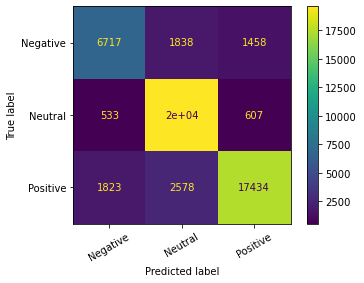

In [62]:
model_eval(logreg_mm, X_train_mm, X_val_mm, y_train, y_val)

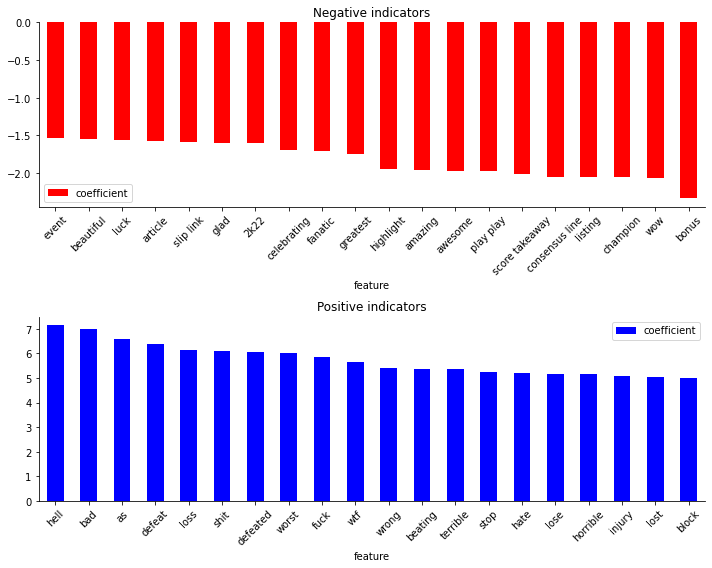

In [63]:
plot_coefs(logreg_mm, X_train)

This is a **significantly** more accurate model and scaling the data clearly had a positive effect on the data.  Unfortunately, the model did the poorest on predicting 'Negative' tweets despite applying SMOTE to the training data.  However, the overall improvement was significant.

That being said, it seems that this model over guesses Neutral in general, but then also guesses Positive for Negative and vice versa.  It seems stronger at separating Positive and Negative tweets from Neutral ones.

I'll try the same and see if Standard Scaling is a better option.

In [64]:
# Scale the data with Standard
ss = StandardScaler().fit(X_train)
X_train_ss = ss.transform(X_train)
X_val_ss = ss.transform(X_val)

In [65]:
logreg_ss = LogisticRegression(multi_class = 'multinomial',
                               max_iter = 1000)

In [66]:
logreg_ss.fit(X_train_ss, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

Training Score: 84.6485%
Testing Score: 83.2037%
              precision    recall  f1-score   support

    Negative       0.74      0.67      0.71     10013
     Neutral       0.82      0.95      0.88     20735
    Positive       0.89      0.80      0.84     21835

    accuracy                           0.83     52583
   macro avg       0.82      0.80      0.81     52583
weighted avg       0.83      0.83      0.83     52583



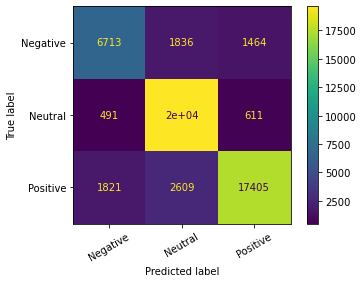

In [67]:
model_eval(logreg_ss, X_train_ss, X_val_ss, y_train, y_val)

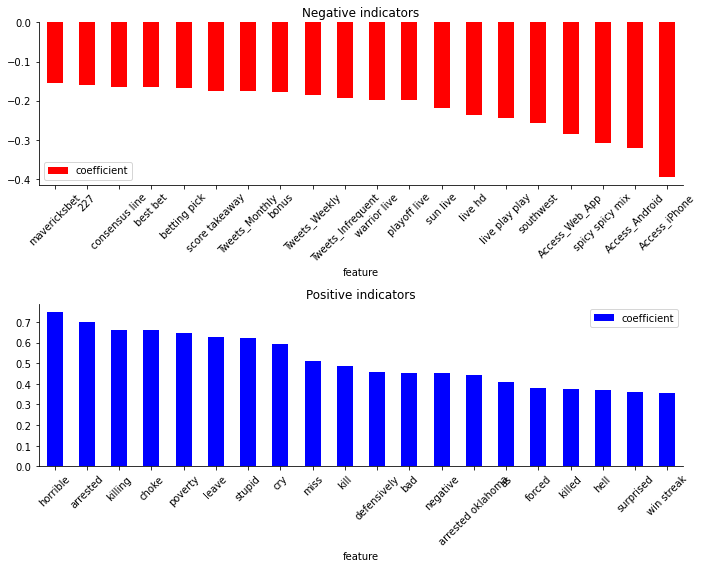

In [68]:
plot_coefs(logreg_ss, X_train)

There was a marginal improvement with the Standard Scaler versus the MinMax Scaler, though very similar in the overall score, as well in the ways that the model missed predictions.

It took a significant amount of time for the model to fit locally on my computer so some dimensionality reduction may be needed if I am going to do additional modeling.  I will use PCA to reduce the dimensionality.  The data using the standard scaler performed better, so I will use that first to see how a model with PCA-data performs.

In [69]:
mavs_pca = PCA().fit(X_train_ss)
mavs_pca_array = mavs_pca.transform(X_train_ss)
mavs_exp_var = mavs_pca.explained_variance_ratio_

In [70]:
mavs_pca_df = pd.DataFrame(data = mavs_pca_array)

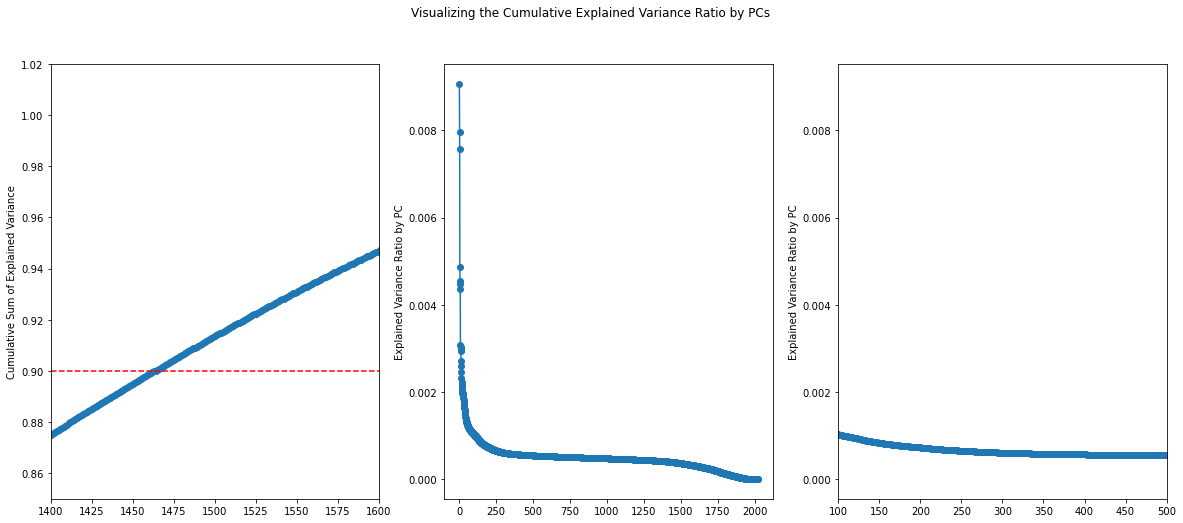

In [71]:
plt.subplots(1,3,figsize=(20,8))
plt.suptitle("Visualizing the Cumulative Explained Variance Ratio by PCs")

# scree plot - visualizing cumulative variance captured
plt.subplot(1,3,1)
plt.plot(mavs_pca_df.columns, mavs_exp_var.cumsum(), marker='o')
plt.axhline(0.9, color='red', linestyle='--')
plt.ylim(0.85, 1.02)
plt.xlim(1400, 1600)
plt.ylabel('Cumulative Sum of Explained Variance')

plt.subplot(1,3,2)
plt.plot(mavs_pca_df.columns, mavs_exp_var, marker='o')
plt.ylabel('Explained Variance Ratio by PC')

plt.subplot(1,3,3)
plt.plot(mavs_pca_df.columns, mavs_exp_var, marker='o')
plt.xlim(100, 500)
plt.ylabel('Explained Variance Ratio by PC')

plt.show()

It looks as though around 1460 PC's explains 90% of the Cumulative Variance in the data.  This number of PC's coincides with an additional drop in the explained variance per PC.  This would seem to be an appropriate point to minimize the dimensionality of the data.

Visually inspecting the 'elbow' of the Explained Variance Ratio plot, the most significant change comes at around 300 PC's.  I will try to use these two points as benchmarks to see if we can effectively use PCA to reduce the dimensionality of the data in order to conduct more vigorous prediction models.

In [72]:
pca_1460 = PCA(n_components = 1460).fit(X_train_ss)
X_train_pca_1460 = pca_1460.transform(X_train_ss)

In [73]:
X_val_pca_1460 = pca_1460.transform(X_val_ss)

In [74]:
pca_300 = PCA(n_components = 300).fit(X_train_ss)
X_train_pca_300 = pca_300.transform(X_train_ss)

In [75]:
X_val_pca_300 = pca_300.transform(X_val_ss)

In [76]:
logreg_pca1460 = LogisticRegression(multi_class = 'multinomial',
                                    max_iter = 1000)

In [77]:
logreg_pca1460.fit(X_train_pca_1460, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

Training Score: 80.3505%
Testing Score: 78.4759%
              precision    recall  f1-score   support

    Negative       0.66      0.67      0.66     10013
     Neutral       0.78      0.87      0.82     20735
    Positive       0.86      0.75      0.80     21835

    accuracy                           0.78     52583
   macro avg       0.77      0.77      0.76     52583
weighted avg       0.79      0.78      0.78     52583



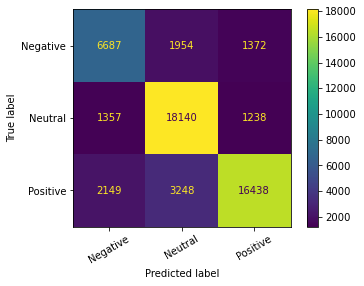

In [78]:
model_eval(logreg_pca1460, X_train_pca_1460, X_val_pca_1460, y_train, y_val)

In [79]:
logreg_pca300 = LogisticRegression(multi_class = 'multinomial',
                                   max_iter = 1000)

In [80]:
logreg_pca300.fit(X_train_pca_300, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

Training Score: 65.4927%
Testing Score: 62.8207%
              precision    recall  f1-score   support

    Negative       0.45      0.61      0.51     10013
     Neutral       0.67      0.67      0.67     20735
    Positive       0.72      0.60      0.65     21835

    accuracy                           0.63     52583
   macro avg       0.61      0.63      0.61     52583
weighted avg       0.65      0.63      0.63     52583



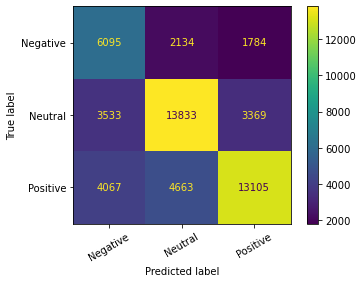

In [81]:
model_eval(logreg_pca300, X_train_pca_300, X_val_pca_300, y_train, y_val)

The performance of the validation data in the PCA models was worse the fewer PC's that were used in the model.  However, the model using 1460 PC's had a less severe decrease in performance in the model, with an improvement in speed locally.

Given the computational challenges on running this locally, I will just optimize the Logistic Regression based on the solver to use for the model.  Ideally, I would also optimize for the c_value for each solver as well, but given the size of the data this will not be practical at this time.

Given that this is a larger dataset, and a multinomial problem, I will use try to use the following solvers to optimize the logistic regression model:

1) 'lbfgs' - This is the default in sklearn so has already been completed

2) 'sag' or Stochastic Average Gradient

3) 'saga'

Both 'sag' and 'saga' can be used for multinomial problems and are theoretically better for larger (sag) and sparse (saga) datasets.  Some helpful additional education on these solvers was found [HERE](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions)

First, I will try the 'sag' solver.

In [82]:
logreg_sag = LogisticRegression(multi_class = 'multinomial',
                            max_iter = 1000,
                            solver = 'sag')
logreg_sag.fit(X_train_ss, y_train)

/Users/brianjohns/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', solver='sag')

Training Score: 84.6343%
Testing Score: 83.2056%
              precision    recall  f1-score   support

    Negative       0.74      0.67      0.71     10013
     Neutral       0.82      0.95      0.88     20735
    Positive       0.89      0.80      0.84     21835

    accuracy                           0.83     52583
   macro avg       0.82      0.80      0.81     52583
weighted avg       0.83      0.83      0.83     52583



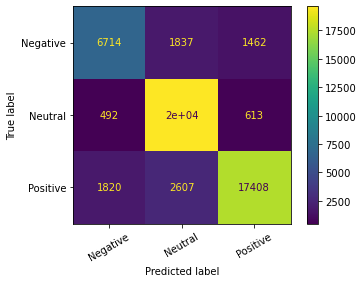

In [83]:
model_eval(logreg_sag, X_train_ss, X_val_ss, y_train, y_val)

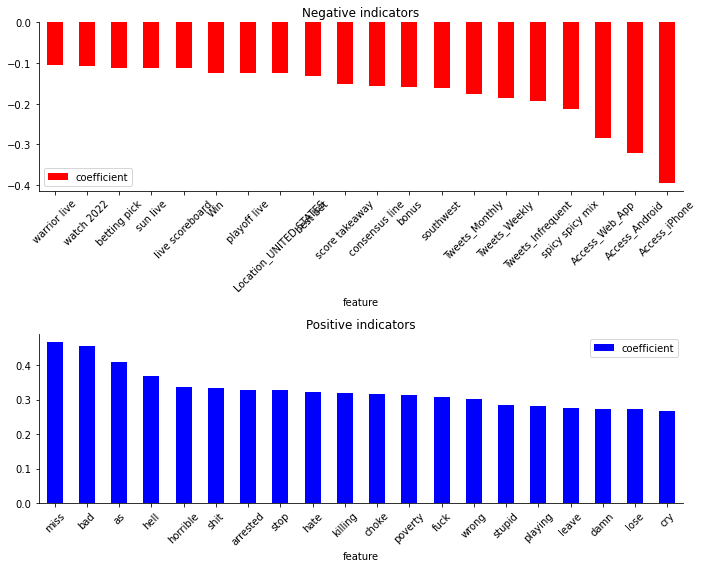

In [84]:
plot_coefs(logreg_sag, X_train)

There is a very marginal increase in performance between the lbfgs solver and the sag solver, with very similar performance in precision and recall across all classes.

There is no appreciable improvement in the model here, so I will now try using 'saga' as the solver for the logistic regression model, still using Standard Scaled data.

In [85]:
logreg_saga = LogisticRegression(multi_class = 'multinomial',
                            max_iter = 1000,
                            solver = 'saga')
logreg_saga.fit(X_train_ss, y_train)

/Users/brianjohns/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

Training Score: 84.6307%
Testing Score: 83.2075%
              precision    recall  f1-score   support

    Negative       0.74      0.67      0.71     10013
     Neutral       0.82      0.95      0.88     20735
    Positive       0.89      0.80      0.84     21835

    accuracy                           0.83     52583
   macro avg       0.82      0.80      0.81     52583
weighted avg       0.83      0.83      0.83     52583



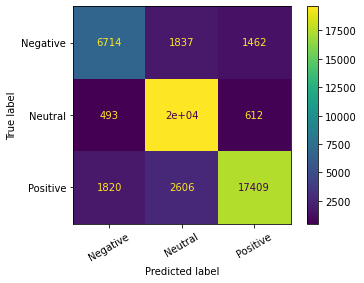

In [86]:
model_eval(logreg_saga, X_train_ss, X_val_ss, y_train, y_val)

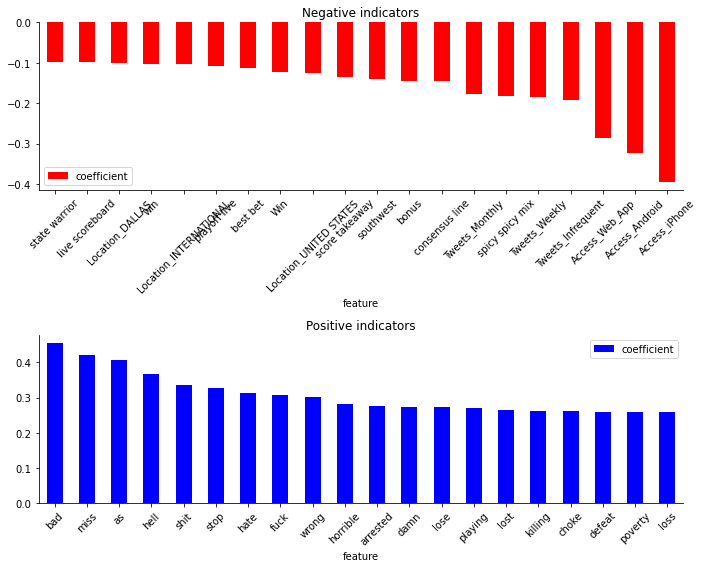

In [87]:
plot_coefs(logreg_saga, X_train)

This is technically the best performing model.  To recap, this is how the Logistic Regression accuracy scores were by solver:

lfgbs: 83.2037%

sag: 83.2056%

saga: 83.2075%

While there was some marginal improvement modifying the solver, the computing speed of the models using sag and saga as the solvers was significantly slower than the lfgbs solver.  Given the marginal gains in improvement, with each model performing similarly in regards to identifying specific classes, I believe that the lfgbs model is the best so far.

Perhaps using a Bayesian method will provide better accuracy at less computational cost.

<a id = 'bayes'></a>

## 4. Classification Modeling Using Naive Bayes


In [88]:
mnb = MultinomialNB()

In [89]:
# Multinomial NB requires non-negative numbers, so the MinMax Scaled data will be used
mnb.fit(X_train_mm, y_train)

MultinomialNB()

Training Score: 75.1625%
Testing Score: 72.3238%
              precision    recall  f1-score   support

    Negative       0.52      0.70      0.60     10013
     Neutral       0.79      0.73      0.76     20735
    Positive       0.79      0.73      0.76     21835

    accuracy                           0.72     52583
   macro avg       0.70      0.72      0.71     52583
weighted avg       0.74      0.72      0.73     52583



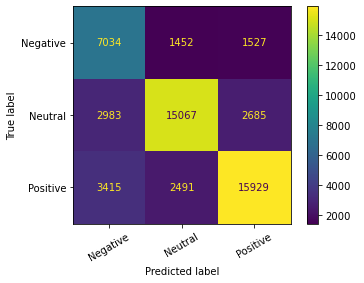

In [90]:
model_eval(mnb, X_train_mm, X_val_mm, y_train, y_val)

Using Naive Bayes performs significantly worse than using Logistic Regression, with a decrease in accuracy by approximately 11%.  More significantly, there was a significant decrease in the precision in classifying Negative and Positive `Sentiment`, dropping from 74% to 52% and 89% to 79% respectively.

Considering that the computational power required to run the Naive Bayes model is significantly, I will try to optimize the model by finding the best alpha values.  In a text classification model, changing the alpha value will increase the probability of text with unseen words to 'not zero'.  Hopefully by increasing the alpha value, the model will be able make better predictions for positive and negative values and increase the overall accuracy of the model.

In [91]:
scores = []
alphas = list(range(-9,1))

for alpha in alphas:
    mnb = MultinomialNB(alpha = 10**alpha)
    mnb.fit(X_train_mm, y_train)
    scores.append(mnb.score(X_val_mm, y_val))

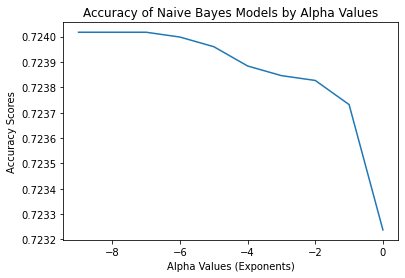

In [92]:
plt.figure()
sns.lineplot(x = alphas, y = scores)
plt.title('Accuracy of Naive Bayes Models by Alpha Values')
plt.ylabel('Accuracy Scores')
plt.xlabel('Alpha Values (Exponents)')
plt.show()

At first glance, it is not promising that the Naive Bayes model will be able to outperform the logistic regression models.  It seems that having an alpha value less than 0.01 does improve the initial score, with the more miniscule the number the better the accuracy and plateauing at 10^-7.

I will try that value and see if that improves the model.

In [98]:
mnb = MultinomialNB(alpha = 10**-7)
mnb.fit(X_train_mm, y_train)

MultinomialNB(alpha=1e-07)

Training Score: 75.3233%
Testing Score: 72.4017%
              precision    recall  f1-score   support

    Negative       0.52      0.71      0.60     10013
     Neutral       0.80      0.72      0.76     20735
    Positive       0.79      0.73      0.76     21835

    accuracy                           0.72     52583
   macro avg       0.70      0.72      0.71     52583
weighted avg       0.74      0.72      0.73     52583



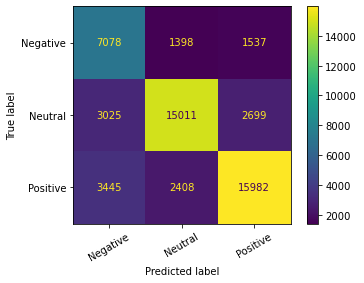

In [99]:
model_eval(mnb, X_train_mm, X_val_mm, y_train, y_val)

This did improve the overall accuracy of the model, but just by 0.1% with no measurable gains for the precision of Negative and Positive `Sentiment`.  It is clear that using a frequentist model such as Logistic Regression significantly outperforms the bayesian model.


<a id = 'evaluation'></a>

## 5. Model Evaluation

The best performing model was:

**Logistic Regression**

**Solver** = lfgbs

**Scale** = Standard Scaling

To further evaluate this model, I will plot the ROC Curve and the Area Under the Curve (AUC) to better understand the model.  Given that this is a multi-class problem, and the ROC Curve can only be given as a binary, I will need to plot the ROC curve for **each** `Sentiment` in a one-vs-rest manner.

I can first binarize the classification labels and then use the labels to display the ROC Curve for each `Sentiment`.  Much of what is below is adapted directly from the [Scikit Learn Library HERE](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [95]:
label_binarizer = LabelBinarizer().fit(y_train)
y_ohe_val = label_binarizer.transform(y_val)

In [96]:
y_score = logreg_ss.predict_proba(X_val_ss)

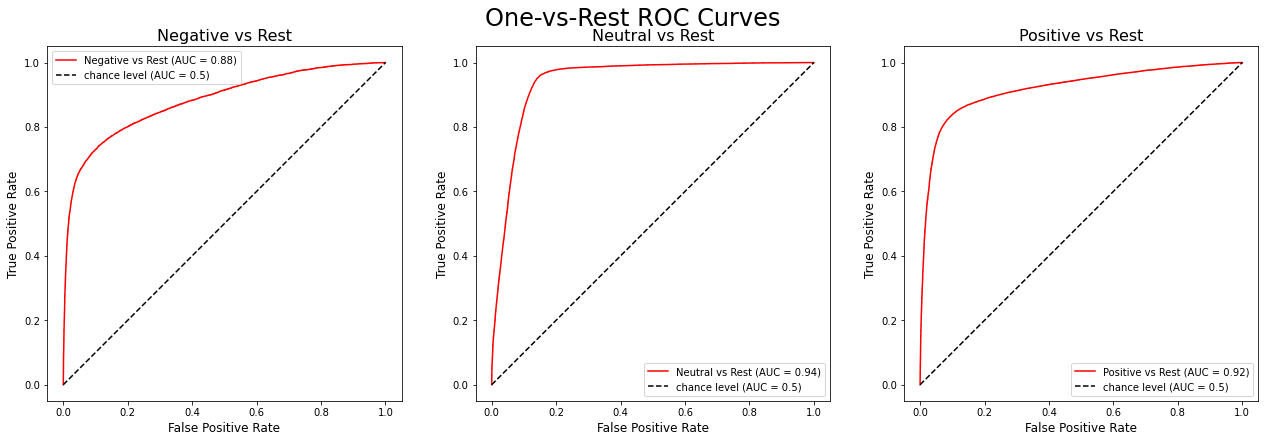

In [97]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.suptitle('One-vs-Rest ROC Curves', fontsize = 24)

for n, sentiment in enumerate(label_binarizer.classes_):
    ax = axes[n]
    
    class_id = np.flatnonzero(label_binarizer.classes_ == sentiment)[0]
    
    RocCurveDisplay.from_predictions(
        y_ohe_val[:, class_id],
        y_score[:, class_id],
        name=f"{sentiment} vs Rest",
        color="red",
        ax=ax)
    
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax.axis("square")
    ax.set_xlabel("False Positive Rate", fontsize = 12)
    ax.set_ylabel("True Positive Rate", fontsize = 12)
    ax.set_title(f"{sentiment} vs Rest", fontsize = 16)
    ax.legend()

plt.tight_layout()
plt.show()

It is unsurprisingly that the AUC value is the lowerst for Negative `Sentiment` considering the predictive challenges so far as it is the minority class. Interestingly, although the precision score was the highest for Positive `Sentiment`, it is Neutral `Sentiment` that had the highest AUC average.  This suggests that the model is more *certain* in differentiating between Neutral vs Positive/Negative, and less certain differentiating Positive or Negative vs the others.

That being said, the AUC values of each class is high and suggests a strong amount of certainty in the predictions for each class relative to the accuracy score of the model.

With this, I am satisfied that this Logistic Regression model is the best option to move forward with to finalize this project.

In the next notebook, I will use this model in order to evaluate its performance on the test data and to analyze the findings for practical use.